## FACT: There are over 127 million acres of agricultural land in the Midwest and in addition to 75% of that area in corn  and soybeans, the other 25% is used to produce alfalfa, apples, asparagus, green beans, blueberries,   cabbage, carrots, sweet and tart cherries, cranberries, cucumbers, grapes, oats, onions, peaches, plums,  peas, bell peppers, potatoes, pumpkins, raspberries, strawberries, sweet corn, tobacco, tomatoes, watermelon, and wheat.

In [1]:
#https://www.investopedia.com/terms/v/vwap.asp
#https://towardsdatascience.com/lstm-for-time-series-prediction-de8aeb26f2ca

# Recurrent Neural Network

#https://www.youtube.com/watch?v=zwqwlR48ztQ

# Recurrent Neural Network

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
dataset_train = pd.read_csv('./marketdata/soybean/zsk20_daily_price-history-10-25-2019.csv')
#dataset_train = dataset_train[dataset_train["Volume"] != 0]

dataset_train.Time = pd.to_datetime(dataset_train.Time.str.replace('D', 'T'))
dataset_train = dataset_train.sort_values('Time')
dataset_train.set_index('Time', inplace=True)
dataset_train.shape

(490, 7)

In [2]:
dataset_train.head()

,Open,High,Low,Last,Change,Volume,Open Int
Time,,,,,,,
2017-11-15,985.0,985.0,985.0,985.0,6.5,0,0
2017-11-16,991.0,991.0,991.0,991.0,6.0,0,0
2017-11-17,1004.5,1004.5,1004.5,1004.5,13.5,0,0
2017-11-20,1006.5,1006.5,1006.5,1006.5,2.0,0,0
2017-11-21,1006.0,1006.0,1006.0,1006.0,-0.5,0,0


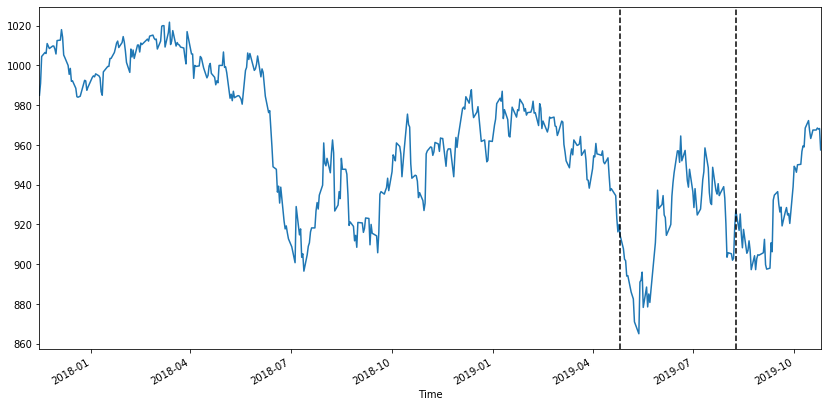

In [3]:
ax = dataset_train["Last"].plot(figsize=(14, 7))
ax.axvline("26-04-2019", linestyle="--", c="black")
ax.axvline("08-09-2019", linestyle="--", c="black")

In [4]:
# Feature Scaling
training_set = dataset_train.iloc[:, 1:7].values

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (-1, 1))
training_set_scaled = sc.fit_transform(training_set)

In [5]:
# Creating a data structure with 15 timesteps and 1 output - we use last 15 prices to predict next. 
#This takes data from 15th row onwards
X_whole = []
y_whole = []

X_whole_vchange = []
y_whole_vchange = []


X_whole_wvap = []
y_whole_wvap = []

sequence_size = 1
for i in range(sequence_size, len(training_set_scaled)):
    X_whole = np.append(X_whole, training_set_scaled[i-sequence_size:i, 2])
    #X_whole = np.append(X_whole, training_set_scaled[i, 6])
    #X_whole = np.append(X_whole, training_set_scaled[i, 7])
    vwap = 0
    vol = 0
    vchg = 0
    for j in range(sequence_size):
        if (j+i<training_set_scaled.shape[0]):
            vwap += (((np.sum(training_set_scaled[j+i, 0:3]))/3) * training_set_scaled[j+i, 4])
            vchg += (((training_set_scaled[j+i, 3])) * training_set_scaled[j+i, 4])
            vol += training_set_scaled[j+i, 4]
    #if vwap !=0  and vol != 0:
    X_whole = np.append(X_whole, vwap/vol)
    X_whole = np.append(X_whole, vchg/vol)
    y_whole.append(training_set_scaled[i, 0])

sz = training_set_scaled.shape[0]-sequence_size
X_whole, y_whole = np.array(X_whole.reshape(sz,sequence_size+2)), np.array(y_whole)


for i in range(sequence_size, len(X_whole)):
    X_whole_wvap = np.append(X_whole_wvap,X_whole[i-sequence_size:i, sequence_size])
    X_whole_wvap = np.append(X_whole_wvap,X_whole[i, 0])
    X_whole_wvap = np.append(X_whole_wvap,X_whole[i, sequence_size+1])
    y_whole_wvap.append(X_whole[i, sequence_size])
    
    X_whole_vchange = np.append(X_whole_vchange,X_whole[i-sequence_size:i, sequence_size+1])
    X_whole_vchange = np.append(X_whole_vchange,X_whole[i, 0])
    X_whole_vchange = np.append(X_whole_vchange,X_whole[i, sequence_size])
    y_whole_vchange.append(X_whole[i, sequence_size+1])

sz1 = X_whole.shape[0]-sequence_size
X_whole_wvap, y_whole_wvap = np.array(X_whole_wvap.reshape(sz1,sequence_size+2)), np.array(y_whole_wvap)
X_whole_vchange, y_whole_vchange = np.array(X_whole_vchange.reshape(sz1,sequence_size+2)), np.array(y_whole_vchange)

In [ ]:
#print(X_whole_wvap)
#print(y_whole_wvap)

In [6]:
#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()


X_train_wvap = X_whole_wvap[0:362,:].copy()
X_valid_wvap = X_whole_wvap[362:420,:].copy()
X_test_wvap = X_whole_wvap[420:,:].copy()

y_train_wvap = y_whole_wvap[0:362].copy()
y_valid_wvap = y_whole_wvap[362:420].copy()
y_test_wvap = y_whole_wvap[420:].copy()

X_train_vchange = X_whole_vchange[0:362,:].copy()
X_valid_vchange = X_whole_vchange[362:420,:].copy()
X_test_vchange = X_whole_vchange[420:,:].copy()

y_train_vchange = y_whole_vchange[0:362].copy()
y_valid_vchange = y_whole_vchange[362:420].copy()
y_test_vchange = y_whole_vchange[420:].copy()

In [7]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

X_train_wvap = np.reshape(X_train_wvap, (X_train_wvap.shape[0], X_train_wvap.shape[1], 1))
X_valid_wvap = np.reshape(X_valid_wvap, (X_valid_wvap.shape[0], X_valid_wvap.shape[1], 1))

X_train_vchange = np.reshape(X_train_vchange, (X_train_vchange.shape[0], X_train_vchange.shape[1], 1))
X_valid_vchange = np.reshape(X_valid_vchange, (X_valid_vchange.shape[0], X_valid_vchange.shape[1], 1))

In [ ]:
%%time
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adm = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# Compiling the RNN
regressor.compile(optimizer = adm, loss = 'mean_squared_error' , metrics=["mean_squared_error"])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Fitting the RNN to the Training set
hist = regressor.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs = 150, batch_size = 8, verbose=0)

In [ ]:
plt.figure(figsize=(14,12))
plt.suptitle('Training Evaluation', fontsize=24)

plt.subplot(2,2,1)
#Plotting Training history
print(hist.history.keys())

# Visualising the results
plt.plot(hist.history['loss'], color = 'blue',  label = 'train_loss')
plt.plot(hist.history['val_loss'], color = 'red',  label = 'val_loss')
plt.title('Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.show()
plt.subplot(2,2,2)
# Visualising the results
plt.plot(hist.history['mean_squared_error'], color = 'blue',  label = 'train_mean_squared_error')
plt.plot(hist.history['val_mean_squared_error'], color = 'red',  label = 'val_mean_squared_error')
plt.title('mean_squared_error')
plt.xlabel('epoch')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [ ]:
%%time
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Initialising the RNN
regressorWvap = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressorWvap.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_wvap.shape[1], 1)))
regressorWvap.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressorWvap.add(LSTM(units = 50, return_sequences = True))
regressorWvap.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressorWvap.add(LSTM(units = 50, return_sequences = True))
regressorWvap.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressorWvap.add(LSTM(units = 50))
regressorWvap.add(Dropout(0.2))

# Adding the output layer
regressorWvap.add(Dense(units = 1))

from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adm = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# Compiling the RNN
regressorWvap.compile(optimizer = adm, loss = 'mean_squared_error' , metrics=["mean_squared_error"])

# Fitting the RNN to the Training set
hist = regressorWvap.fit(X_train_wvap, y_train_wvap, validation_data=(X_valid_wvap, y_valid_wvap), epochs = 150, batch_size = 8, verbose=0)

In [ ]:
plt.figure(figsize=(14,12))
plt.suptitle('Training Evaluation', fontsize=24)

plt.subplot(2,2,1)
#Plotting Training history
print(hist.history.keys())

# Visualising the results
plt.plot(hist.history['loss'], color = 'blue',  label = 'train_loss')
plt.plot(hist.history['val_loss'], color = 'red',  label = 'val_loss')
plt.title('Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.show()
plt.subplot(2,2,2)
# Visualising the results
plt.plot(hist.history['mean_squared_error'], color = 'blue',  label = 'train_mean_squared_error')
plt.plot(hist.history['val_mean_squared_error'], color = 'red',  label = 'val_mean_squared_error')
plt.title('mean_squared_error')
plt.xlabel('epoch')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [ ]:
# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
X_test_wvap = np.reshape(X_test_wvap, (X_test_wvap.shape[0], X_test_wvap.shape[1], 1))
predicted_wvap = regressorWvap.predict(X_test_wvap)
# create empty table with 6 fields to inverse

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(y_test_wvap, predicted_wvap)))
print("mean_squared_error: ", mean_squared_error(y_test_wvap, predicted_wvap))
mean_absolute_error = mean_absolute_error(y_test_wvap, predicted_wvap)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(y_test_wvap, color = 'red',  marker='o', label = 'Real vwap')
plt.plot(predicted_wvap, color = 'blue',  marker='o', label = 'Predicted vwap')
plt.title('Vwap Prediction')
plt.xlabel('Time')
plt.ylabel('vwap')
plt.legend()
plt.show()

In [8]:
%%time
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Initialising the RNN
regressorVchange = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressorVchange.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_vchange.shape[1], 1)))
regressorVchange.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressorVchange.add(LSTM(units = 50, return_sequences = True))
regressorVchange.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressorVchange.add(LSTM(units = 50, return_sequences = True))
regressorVchange.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressorVchange.add(LSTM(units = 50))
regressorVchange.add(Dropout(0.2))

# Adding the output layer
regressorVchange.add(Dense(units = 1))

from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adm = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# Compiling the RNN
regressorVchange.compile(optimizer = adm, loss = 'mean_squared_error' , metrics=["mean_squared_error"])

# Fitting the RNN to the Training set
hist = regressorVchange.fit(X_train_vchange, y_train_vchange, validation_data=(X_valid_vchange, y_valid_vchange), epochs = 200, batch_size = 16, verbose=0)

Using TensorFlow backend.


Wall time: 32.5 s


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


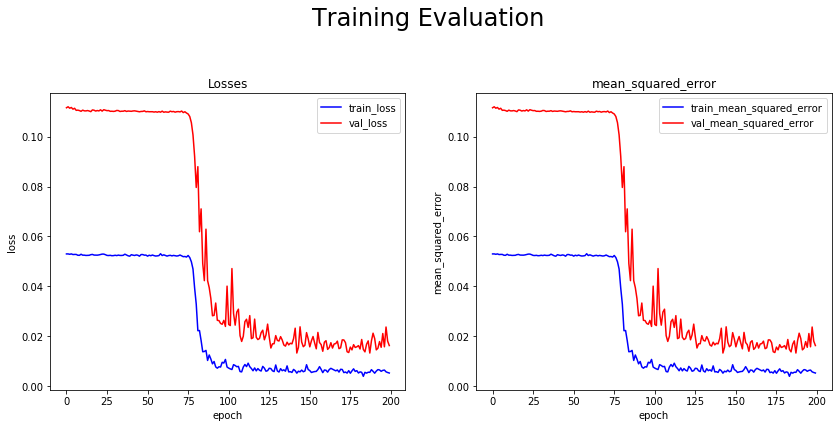

In [9]:
plt.figure(figsize=(14,12))
plt.suptitle('Training Evaluation', fontsize=24)

plt.subplot(2,2,1)
#Plotting Training history
print(hist.history.keys())

# Visualising the results
plt.plot(hist.history['loss'], color = 'blue',  label = 'train_loss')
plt.plot(hist.history['val_loss'], color = 'red',  label = 'val_loss')
plt.title('Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.show()
plt.subplot(2,2,2)
# Visualising the results
plt.plot(hist.history['mean_squared_error'], color = 'blue',  label = 'train_mean_squared_error')
plt.plot(hist.history['val_mean_squared_error'], color = 'red',  label = 'val_mean_squared_error')
plt.title('mean_squared_error')
plt.xlabel('epoch')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

sqrt mean_squared_error:  0.08849729163783449
mean_squared_error:  0.00783177062723193
mean_absolute_error:  0.06844615577255636


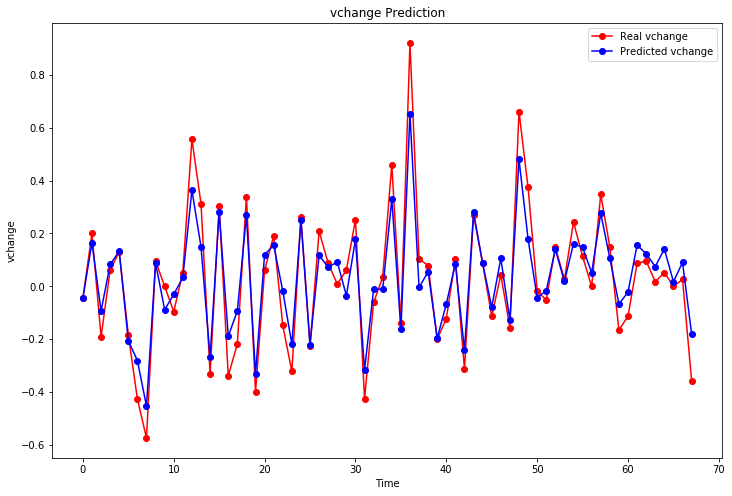

In [11]:
# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
X_test_vchange = np.reshape(X_test_vchange, (X_test_vchange.shape[0], X_test_vchange.shape[1], 1))
predicted_vchange = regressorVchange.predict(X_test_vchange)
# create empty table with 6 fields to inverse

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(y_test_vchange, predicted_vchange)))
print("mean_squared_error: ", mean_squared_error(y_test_vchange, predicted_vchange))
mean_absolute_error = mean_absolute_error(y_test_vchange, predicted_vchange)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(y_test_vchange, color = 'red',  marker='o', label = 'Real vchange')
plt.plot(predicted_vchange, color = 'blue',  marker='o', label = 'Predicted vchange')
plt.title('vchange Prediction')
plt.xlabel('Time')
plt.ylabel('vchange')
plt.legend()
plt.show()

In [ ]:
#create empty table with 6 fields to inverse
test_data = np.zeros(shape=(len(y_test), 6) )
test_data[:,2] = y_test
real_stock_price = sc.inverse_transform(test_data)[:,2]
#real_stock_price

In [ ]:
# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
# create empty table with 6 fields to inverse
test_data = np.zeros(shape=(len(predicted_stock_price), 6) )
test_data[:,2] = predicted_stock_price.reshape(1,-1)
predicted_stock_price = sc.inverse_transform(test_data)[:,2]

#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
#real_stock_price, predicted_stock_price
SS_Residual = sum((real_stock_price-predicted_stock_price)**2)
SS_Total = sum((real_stock_price-np.mean(real_stock_price))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(real_stock_price)-1)/(len(real_stock_price)-X_train.shape[1]-1)
print ("R Squared:", r_squared, "\nAdjusted R Squared:", adjusted_r_squared)

In [ ]:
#predicting on new data
xw=X_whole[-1:]
xw=xw.reshape(1,-1)
xw=np.reshape(xw,(xw.shape[0], xw.shape[1], 1))

xwvap = X_whole_xwvap[-1:]
xwvap=xwvap.reshape(1,-1)
xwvap=np.reshape(xwvap,(xwvap.shape[0], xwvap.shape[1], 1))

xvchange=X_whole_vchange[-1:]
xvchange=xvchange.reshape(1,-1)
xvchange=np.reshape(xvchange,(xvchange.shape[0], xvchange.shape[1], 1))

y_pred_w = []
y_pred_wvap = []
y_pred_vchange = []

num_of_pred = 6

for i in range(0,num_of_pred):

    y_pred=regressor.predict(ins)
    y_transformed = sc.inverse_transform(y_pred)[:,2]
    y_pred_w = np.append(y_pred_w,y_transformed)
    
    
    
    
    
    ins=np.append(ins,y_pred)
    ins=np.delete(ins,0)
    #print(ins)
    ins=ins.reshape(1,-1)
    ins=np.reshape(ins,(ins.shape[0], ins.shape[1], 1))
    #print(ins)
        
print(y_predicted)